In [ ]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns

# *1. Анализ ассортимента конкурента в различных разрезах* #

Загрузим данные ассортимента конкурента в датафрейм:

In [ ]:
competitor_data = pd.read_excel('/content/abc-xyz.xlsx', sheet_name=1)
competitor_data

,Код группы,Код товара,Категория,Название,Бренд,Старая цена,Цена по промокоду,Цена,Количество отзывов,Количество покупок,Ссылка на товар
0,894976,1017653,Дом и дача/Ванная/Полотенца/Полотенца банные,Полотенце банное - 2 шт. (стерильное),ФЭСТ,702,387,387.0,39,700,https://www.конкурент.ru/catalog/1017653/
1,895229,1018029,Дом и дача/Постельные принадлежности/Комплекты...,Постельное белье,Василек,1300,1170,1170.0,54,1400,https://www.конкурент.ru/catalog/1018029/
2,901702,1026067,"Дом и дача/Творчество, рукоделие/Наборы для по...","Игровой набор ""10 пушистиков из помпончиков""",Fun kits,955,687,687.0,9,70,https://www.конкурент.ru/catalog/1026067/
3,901704,1026069,"Дом и дача/Творчество, рукоделие/Наборы для по...","Набор ""Стильные тату""",Мини-маэстро,510,408,408.0,12,100,https://www.конкурент.ru/catalog/1026069/
4,901705,1026070,"Дом и дача/Творчество, рукоделие/Наборы для ри...","Набор ""Роспись по шелку""",Мини-маэстро,505,363,363.0,2,50,https://www.конкурент.ru/catalog/1026070/
...,...,...,...,...,...,...,...,...,...,...,...
225056,868317,976542,Дом и дача/Постельные принадлежности/Покрывала,Покрывало,Primavelle,6350,5080,5080.0,3,40,https://www.конкурент.ru/catalog/976542/
225057,868384,976609,Дом и дача/Кухня/Кухонный текстиль/Скатерти,Скатерть,Primavelle,1350,1080,1080.0,4,30,https://www.конкурент.ru/catalog/976609/
225058,868386,976611,Дом и дача/Кухня/Кухонный текстиль/Скатерти,Скатерть,Primavelle,1350,1080,1080.0,8,50,https://www.конкурент.ru/catalog/976611/
225059,881574,998025,Дом и дача/Кухня/Столовые приборы/Вилки столовые,Набор вилок,Vitesse,0,0,NaN,7,100,https://www.конкурент.ru/catalog/998025/


In [ ]:
competitor_data.drop(['Код группы'], axis=1, inplace=True)

In [ ]:
print('Дубликатов в датафрейме: %i шт.' % competitor_data.duplicated().sum())

Дубликатов в датафрейме: 0 шт.


In [ ]:
competitor_data.dtypes

Категория              object
Название               object
Бренд                  object
Старая цена             int64
Цена по промокоду       int64
Цена                  float64
Количество отзывов      int64
Количество покупок      int64
dtype: object

In [ ]:
competitor_data.isna().sum()

Категория                0
Название                 0
Бренд                    0
Старая цена              0
Цена по промокоду        0
Цена                  6346
Количество отзывов       0
Количество покупок       0
dtype: int64

В стоблце "Цена" присутствуют 6346 пропущенных значения.

In [ ]:
competitor_data.dropna(inplace=True)

Проверим наличие аномалий через описательную статистику:

In [ ]:
competitor_data.describe()

,Старая цена,Цена по промокоду,Цена,Количество отзывов,Количество покупок
count,218715.000000,218715.000000,218715.000000,218715.000000,218715.000000
mean,2402.938043,1689.786850,1689.786850,4.593860,57.464984
std,3864.982577,2425.090758,2425.090758,22.944961,504.434646
min,0.000000,50.000000,50.000000,0.000000,0.000000
25%,450.000000,435.000000,435.000000,0.000000,1.000000
50%,1200.000000,955.000000,955.000000,0.000000,6.000000
75%,2847.000000,2000.000000,2000.000000,3.000000,30.000000
max,142999.000000,92949.000000,92949.000000,1373.000000,100000.000000


In [ ]:
print('%i брендов' % competitor_data['Бренд'].nunique(), 'представлено в %i различных категориях.' % competitor_data['Категория'].nunique())

3853 брендов представлено в 738 различных категориях.


Выделим из столбца категорий основные (верхнеуровневые) категории:

In [ ]:
competitor_data['Осн. категория'] = competitor_data['Категория']
competitor_data['Осн. категория'] = competitor_data['Осн. категория'].apply(lambda x: re.search('Дом и дача/(.*?)/', x).group(1))

In [ ]:
print('Основные категории:\n')
for i in competitor_data['Осн. категория'].unique():
  print(i)

Основные категории:

Ванная
Постельные принадлежности
Творчество, рукоделие
Шторы
Освещение
Предметы интерьера
Отдых на природе
Кухня
Все для праздника
Хранение вещей
Товары для бани
Хозяйственные товары
Дачный сезон
Мебель
Профессиональные музыкальные инструменты
Религия, эзотерика
Кронштейны


Добавим столбец со значением суммы покупок:

In [ ]:
 competitor_data['Сумма покупок'] =  competitor_data['Цена'] * competitor_data['Количество покупок']

Посмотрим на топ-50 самых продаваемых товаров:

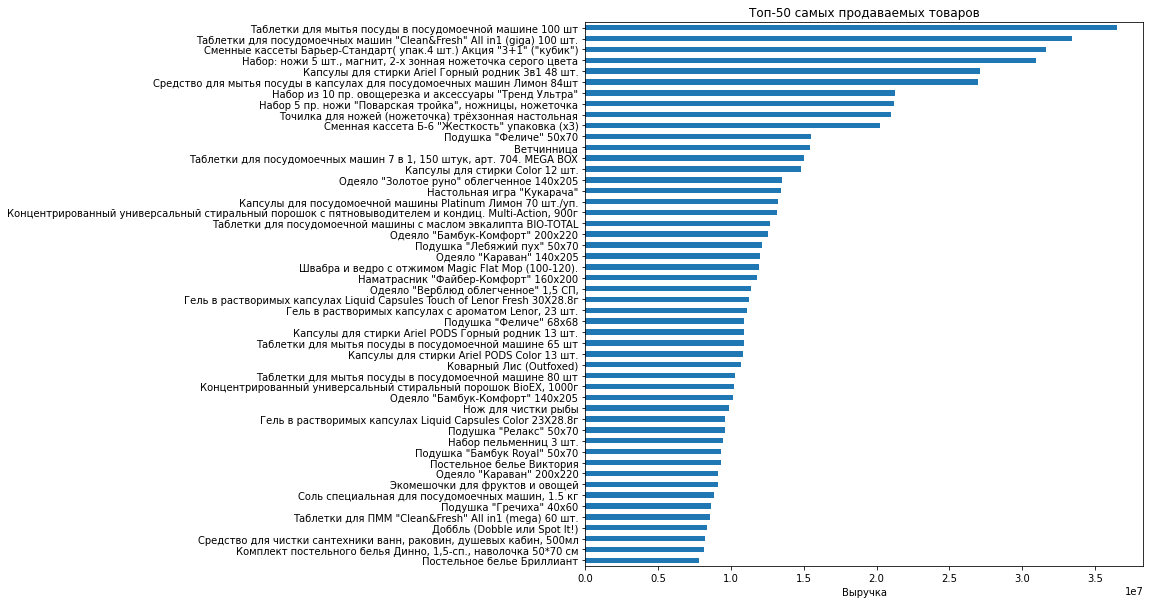

In [ ]:
ax = competitor_data.nlargest(50, 'Сумма покупок').plot(x='Название', y='Сумма покупок', kind='barh', figsize=(10, 10));
ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Топ-50 самых продаваемых товаров');
ax.set(xlabel='Выручка', ylabel=None);

In [ ]:
print('%i уникальных товаров из %i были не востребованы покупателями' % (len(competitor_data[competitor_data['Количество покупок'] == 0]), len(competitor_data)) )

41242 уникальных товаров из 218715 были не востребованы покупателями


Посмотрим на топ-50 самых продаваемых брендов:

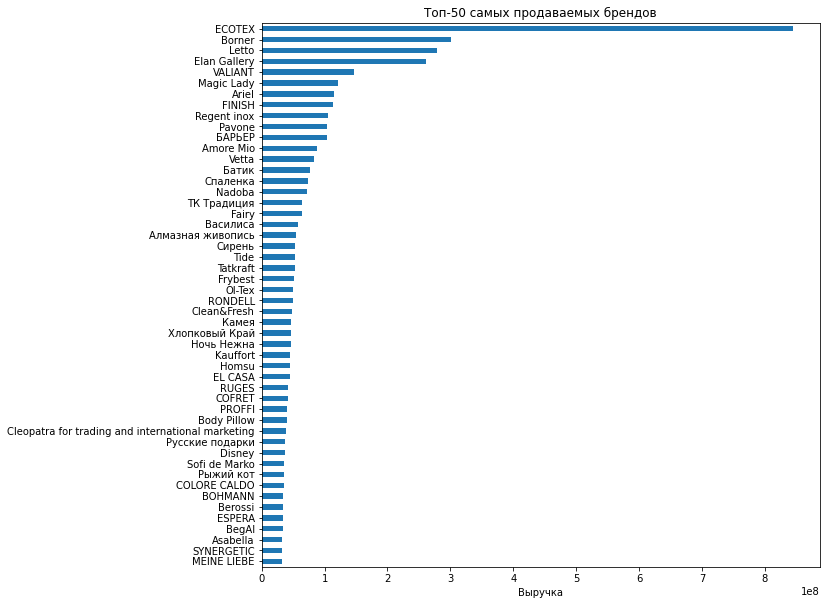

In [ ]:
ax = competitor_data.groupby('Бренд', as_index=False)\
  .agg({'Сумма покупок':'sum'})\
  .sort_values('Сумма покупок', ascending=False)\
  .nlargest(50, 'Сумма покупок')\
  .plot(x='Бренд', y='Сумма покупок', kind='barh', figsize=(10, 10));
  
ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Топ-50 самых продаваемых брендов');
ax.set(xlabel='Выручка', ylabel=None);

In [ ]:
df_brand = competitor_data.groupby('Бренд', as_index=False).agg({'Сумма покупок':'sum'})

print('%i различных брендов из %i были не востребованы покупателями' % (len(df_brand[df_brand['Сумма покупок'] == 0]), len(df_brand)) )

165 различных брендов из 3823 были не востребованы покупателями


Посмотрим как суммарная выручка разбита по сегментам:

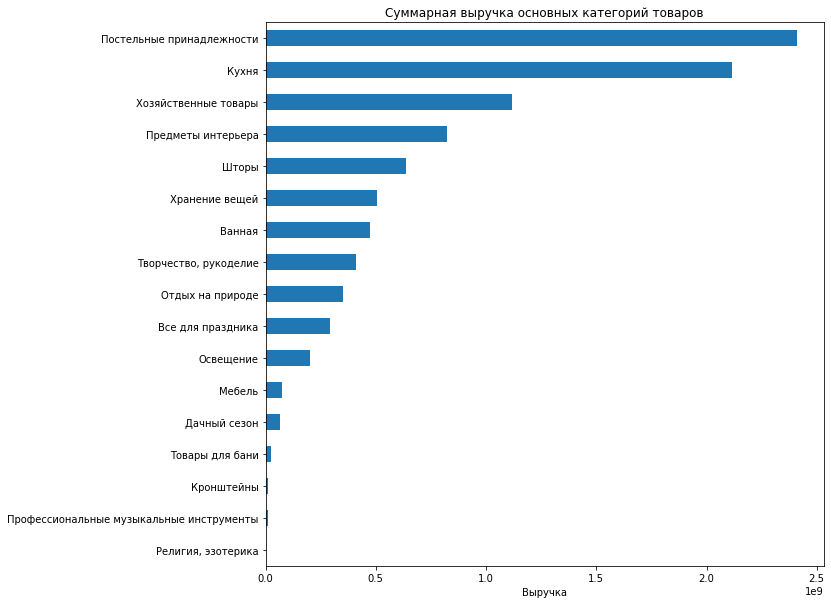

In [ ]:
ax = competitor_data.groupby('Осн. категория', as_index=False)\
  .agg({'Сумма покупок':'sum'})\
  .sort_values('Сумма покупок', ascending=False)\
  .plot(x='Осн. категория', y='Сумма покупок', kind='barh', figsize=(10, 10));

ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Суммарная выручка основных категорий товаров');
ax.set(xlabel='Выручка', ylabel=None);

In [ ]:
print('Общая выручка компании: %i' % competitor_data['Сумма покупок'].sum())

Общая выручка компании: 9519605740


Посмотрим насколько широко и насыщенно представлен ассортимент каждой категории:

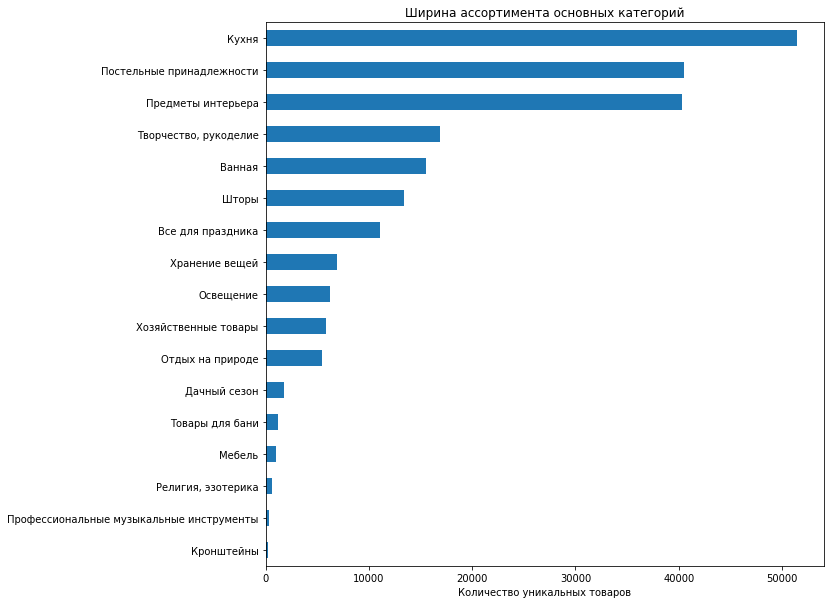

In [ ]:
ax = competitor_data.groupby('Осн. категория', as_index=False)\
  .agg({'Код товара':'count'})\
  .sort_values('Код товара', ascending=False)\
  .plot(x='Осн. категория', y='Код товара', kind='barh', figsize=(10, 10));

ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Ширина ассортимента основных категорий');
ax.set(xlabel='Количество уникальных товаров', ylabel=None);

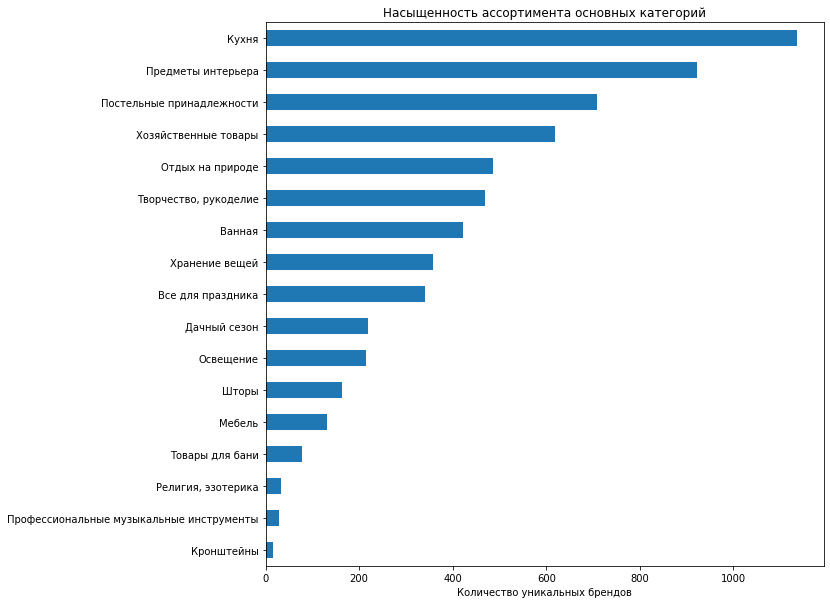

In [ ]:
ax = competitor_data.groupby('Осн. категория', as_index=False)\
  .agg({'Бренд':'nunique'})\
  .sort_values('Бренд', ascending=False)\
  .plot(x='Осн. категория', y='Бренд', kind='barh', figsize=(10, 10));

ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Насыщенность ассортимента основных категорий');
ax.set(xlabel='Количество уникальных брендов', ylabel=None);

#*2. Сравнение ассортимента конкурента с ассортиментом ретейлера по имеющимся данным*#

Загрузим данные ассортимента ретейлера в новый датафрейм:

In [ ]:
main_data = pd.read_excel('/content/abc-xyz.xlsx', sheet_name=2)
main_data

,ID,Тип,Название,Цена,Url
0,5861030,Все для дома и дачи,"Нож для чистки ""Ivo"", длина лезвия 7 см. 30021.07",3791,https://www.конкурент.ru/catalog/4995531/
1,6686610,Все для дома и дачи,"Штора ""Дельфины"" бирюзовая, 180 х 180 см",599,https://www.конкурент.ru/catalog/6434201/
2,6875158,Все для дома и дачи,"Набор чайных кружек ""Assam"", 2 х 350 мл",2137,https://www.конкурент.ru/catalog/6774953/
3,8073410,Все для дома и дачи,"Сменный картридж Барьер ""Стандарт""",184,https://www.конкурент.ru/catalog/2743444/
4,8073414,Все для дома и дачи,"Сменный картридж Барьер ""Жесткость""",193,https://www.конкурент.ru/catalog/2617192/
...,...,...,...,...,...
17323,310913368,Все для дома и дачи,"Сковорода Bohmann, 100922BHMRB, красный, диаме...",1867,https://www.конкурент.ru/catalog/7096020/
17324,310913366,Все для дома и дачи,"Сковорода Bohmann, 100920BHMRB, красный, диаме...",1732,https://www.конкурент.ru/catalog/7096019/
17325,310916958,Все для дома и дачи,"Термос Rainstahl, 7734-10RS\TH, синий, 1 л",972,https://www.конкурент.ru/catalog/5036592/
17326,311061938,Все для дома и дачи,"Френч-пресс Bohmann, 9560BH design4, 600 мл",718,https://www.конкурент.ru/catalog/8151519/


Соеденим 2 датафрейма по Url на сайт конкрента.

In [ ]:
main_data.isnull().sum()

Название_x           0
Цена ретейлера       0
Название_y           0
Бренд                0
Старая цена          0
Цена по промокоду    0
Цена конкурента      0
Осн. категория       0
Разница              0
Разница до акции     0
dtype: int64

In [ ]:
print('Дубликатов в датафрейме: %i шт.' % main_data.duplicated().sum())

Дубликатов в датафрейме: 0 шт.


In [ ]:
main_data = main_data.merge(competitor_data, left_on='Url', right_on='Ссылка на товар')
main_data.head()

,ID,Тип,Название_x,Цена_x,Url,Код товара,Категория,Название_y,Бренд,Старая цена,Цена по промокоду,Цена_y,Количество отзывов,Количество покупок,Ссылка на товар,Осн. категория,Сумма покупок
0,5861030,Все для дома и дачи,"Нож для чистки ""Ivo"", длина лезвия 7 см. 30021.07",3791,https://www.конкурент.ru/catalog/4995531/,4995531,Дом и дача/Кухня/Ножи и аксессуары/Ножи кухонные,Нож для чистки 7см,IVO,4461,3791,3791.0,0,6,https://www.конкурент.ru/catalog/4995531/,Кухня,22746.0
1,6686610,Все для дома и дачи,"Штора ""Дельфины"" бирюзовая, 180 х 180 см",599,https://www.конкурент.ru/catalog/6434201/,6434201,Дом и дача/Ванная/Шторы,Занавеска OCEAN в пакете с подвесом.,Vanstore,0,527,527.0,9,100,https://www.конкурент.ru/catalog/6434201/,Ванная,52700.0
2,6875158,Все для дома и дачи,"Набор чайных кружек ""Assam"", 2 х 350 мл",2137,https://www.конкурент.ru/catalog/6774953/,6774953,Дом и дача/Кухня/Кружки,"Набор кружек чайных Bodum Assam 0,35 л. 2 шт. ...",Bodum,3563,2137,2137.0,0,1,https://www.конкурент.ru/catalog/6774953/,Кухня,2137.0
3,8073410,Все для дома и дачи,"Сменный картридж Барьер ""Стандарт""",184,https://www.конкурент.ru/catalog/2743444/,2743444,Дом и дача/Хозяйственные товары/Кухня/Аксессуа...,"Сменная кассета Б-4 ""Стандарт""",БАРЬЕР,229,217,217.0,104,6900,https://www.конкурент.ru/catalog/2743444/,Хозяйственные товары,1497300.0
4,8073414,Все для дома и дачи,"Сменный картридж Барьер ""Жесткость""",193,https://www.конкурент.ru/catalog/2617192/,2617192,Дом и дача/Хозяйственные товары/Кухня/Аксессуа...,"Сменная кассета Б-6 ""Жесткость""",БАРЬЕР,259,246,246.0,75,6700,https://www.конкурент.ru/catalog/2617192/,Хозяйственные товары,1648200.0


In [ ]:
main_data.drop(['ID', 'Тип', 'Url', 'Код товара', 'Категория', 'Количество отзывов', 'Количество покупок', 'Ссылка на товар', 'Сумма покупок'], axis=1, inplace=True)
main_data

,Название_x,Цена_x,Название_y,Бренд,Старая цена,Цена по промокоду,Цена_y,Осн. категория
0,"Нож для чистки ""Ivo"", длина лезвия 7 см. 30021.07",3791,Нож для чистки 7см,IVO,4461,3791,3791.0,Кухня
1,"Штора ""Дельфины"" бирюзовая, 180 х 180 см",599,Занавеска OCEAN в пакете с подвесом.,Vanstore,0,527,527.0,Ванная
2,"Набор чайных кружек ""Assam"", 2 х 350 мл",2137,"Набор кружек чайных Bodum Assam 0,35 л. 2 шт. ...",Bodum,3563,2137,2137.0,Кухня
3,"Сменный картридж Барьер ""Стандарт""",184,"Сменная кассета Б-4 ""Стандарт""",БАРЬЕР,229,217,217.0,Хозяйственные товары
4,"Сменный картридж Барьер ""Жесткость""",193,"Сменная кассета Б-6 ""Жесткость""",БАРЬЕР,259,246,246.0,Хозяйственные товары
...,...,...,...,...,...,...,...,...
16053,"Ножеточка Bohmann, 02553ВН, зеленый",675,Точилка для ножей,BOHMANN,1500,675,675.0,Кухня
16054,"Сковорода Bohmann, 100922BHMRB, красный, диаме...",1867,Сковорода BH-1009-22-MRB /22см,BOHMANN,4150,1867,1867.0,Кухня
16055,"Сковорода Bohmann, 100920BHMRB, красный, диаме...",1732,Сковорода BH-1009-20-MRB /20 см,BOHMANN,3850,1732,1732.0,Кухня
16056,"Термос Rainstahl, 7734-10RS\TH, синий, 1 л",972,Термос 750мл.,RAINSTAHL,2160,972,972.0,Отдых на природе


In [ ]:
main_data.rename(columns={'Цена_x':'Цена ретейлера', 'Цена_y':'Цена конкурента'}, inplace=True)
main_data

,Название_x,Цена ретейлера,Название_y,Бренд,Старая цена,Цена по промокоду,Цена конкурента,Осн. категория
0,"Нож для чистки ""Ivo"", длина лезвия 7 см. 30021.07",3791,Нож для чистки 7см,IVO,4461,3791,3791.0,Кухня
1,"Штора ""Дельфины"" бирюзовая, 180 х 180 см",599,Занавеска OCEAN в пакете с подвесом.,Vanstore,0,527,527.0,Ванная
2,"Набор чайных кружек ""Assam"", 2 х 350 мл",2137,"Набор кружек чайных Bodum Assam 0,35 л. 2 шт. ...",Bodum,3563,2137,2137.0,Кухня
3,"Сменный картридж Барьер ""Стандарт""",184,"Сменная кассета Б-4 ""Стандарт""",БАРЬЕР,229,217,217.0,Хозяйственные товары
4,"Сменный картридж Барьер ""Жесткость""",193,"Сменная кассета Б-6 ""Жесткость""",БАРЬЕР,259,246,246.0,Хозяйственные товары
...,...,...,...,...,...,...,...,...
16053,"Ножеточка Bohmann, 02553ВН, зеленый",675,Точилка для ножей,BOHMANN,1500,675,675.0,Кухня
16054,"Сковорода Bohmann, 100922BHMRB, красный, диаме...",1867,Сковорода BH-1009-22-MRB /22см,BOHMANN,4150,1867,1867.0,Кухня
16055,"Сковорода Bohmann, 100920BHMRB, красный, диаме...",1732,Сковорода BH-1009-20-MRB /20 см,BOHMANN,3850,1732,1732.0,Кухня
16056,"Термос Rainstahl, 7734-10RS\TH, синий, 1 л",972,Термос 750мл.,RAINSTAHL,2160,972,972.0,Отдых на природе


Создадим столбец с дельтой между ценой конкурента и ценой ретейлера:

In [ ]:
main_data['Разница'] = main_data['Цена ретейлера'] - main_data['Цена конкурента']

Посмотрим, в каких категориях разница между ценами особенно выражена:

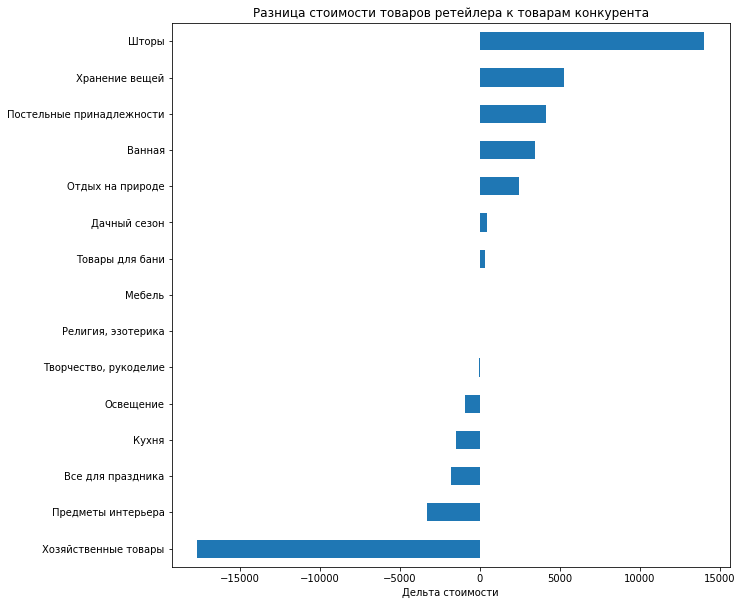

In [ ]:
ax = main_data.groupby('Осн. категория', as_index=False)\
  .agg({'Разница':'sum'})\
  .sort_values('Разница', ascending=False)\
  .plot(x='Осн. категория', y='Разница', kind='barh', figsize=(10, 10));

ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Разница стоимости товаров ретейлера к товарам конкурента');
ax.set(xlabel='Дельта стоимости', ylabel=None);

Имеется существенное превышение стоимости товаров ретейлера, над ценами конкурента в категориях - шторы, хранение вещей, постельные принадлежности, ванная и отдых на природе. Также небольшое превышение в категориях дачный сезон и товары для бани.

Практически на одном уровне цены в категориях мебель, религия-эзотерика, творчество-рукоделие.

И в категориях - освещение, кухня, все для праздника, предметы интерьера, хозяйственные товары - цены ретейлера существенно ниже конкурента.

Исследуем влияние промокодов конкурента на разницу цен:

In [ ]:
# избавимся от нулевых значений в столбце "старая цена"

for i in range(len(main_data)):
  if main_data['Старая цена'][i] == 0:
    main_data['Старая цена'][i] = main_data['Цена по промокоду'][i]

main_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Название_x,Цена ретейлера,Название_y,Бренд,Старая цена,Цена по промокоду,Цена конкурента,Осн. категория,Разница
0,"Нож для чистки ""Ivo"", длина лезвия 7 см. 30021.07",3791,Нож для чистки 7см,IVO,4461,3791,3791.0,Кухня,0.0
1,"Штора ""Дельфины"" бирюзовая, 180 х 180 см",599,Занавеска OCEAN в пакете с подвесом.,Vanstore,527,527,527.0,Ванная,72.0
2,"Набор чайных кружек ""Assam"", 2 х 350 мл",2137,"Набор кружек чайных Bodum Assam 0,35 л. 2 шт. ...",Bodum,3563,2137,2137.0,Кухня,0.0
3,"Сменный картридж Барьер ""Стандарт""",184,"Сменная кассета Б-4 ""Стандарт""",БАРЬЕР,229,217,217.0,Хозяйственные товары,-33.0
4,"Сменный картридж Барьер ""Жесткость""",193,"Сменная кассета Б-6 ""Жесткость""",БАРЬЕР,259,246,246.0,Хозяйственные товары,-53.0
...,...,...,...,...,...,...,...,...,...
16053,"Ножеточка Bohmann, 02553ВН, зеленый",675,Точилка для ножей,BOHMANN,1500,675,675.0,Кухня,0.0
16054,"Сковорода Bohmann, 100922BHMRB, красный, диаме...",1867,Сковорода BH-1009-22-MRB /22см,BOHMANN,4150,1867,1867.0,Кухня,0.0
16055,"Сковорода Bohmann, 100920BHMRB, красный, диаме...",1732,Сковорода BH-1009-20-MRB /20 см,BOHMANN,3850,1732,1732.0,Кухня,0.0
16056,"Термос Rainstahl, 7734-10RS\TH, синий, 1 л",972,Термос 750мл.,RAINSTAHL,2160,972,972.0,Отдых на природе,0.0


In [ ]:
main_data['Разница до акции'] = main_data['Цена ретейлера'] - main_data['Старая цена']

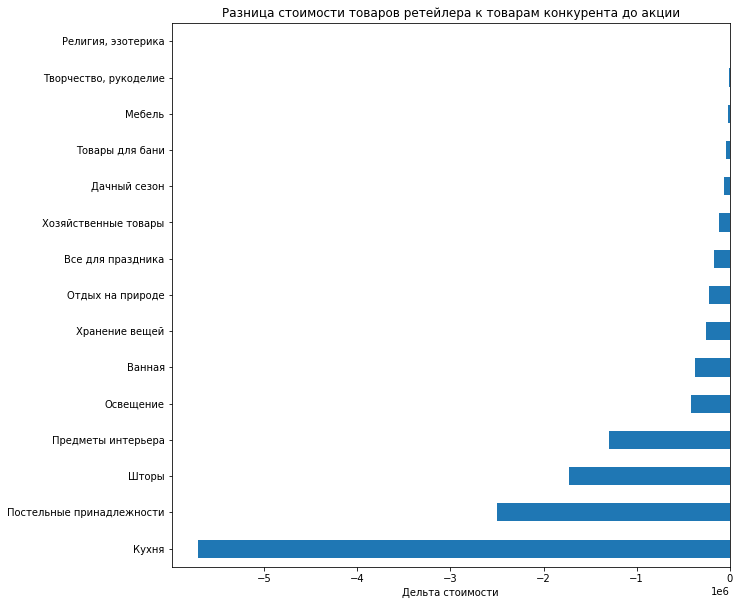

In [ ]:
ax = main_data.groupby('Осн. категория', as_index=False)\
  .agg({'Разница до акции':'sum'})\
  .sort_values('Разница до акции', ascending=False)\
  .plot(x='Осн. категория', y='Разница до акции', kind='barh', figsize=(10, 10));

ax.invert_yaxis()
ax.get_legend().remove()
plt.title('Разница стоимости товаров ретейлера к товарам конкурента до акции');
ax.set(xlabel='Дельта стоимости', ylabel=None);

Все данные лежат в отрицательной плоскости, значит, цена конкурента ниже цен ретейлера только благодаря промокодам.

Для полноты сравнения в таблице товаров конкурента необходимо добавить данные о валюте, временные данные, разбивку отзывов на позитивные/негативные, данные о количестве товара на складе, данные о полной себестоимости или маржинальности.

Для таблицы ретейлера (помимо вышеперечисленного) - данные о категории товаров, количество отзывов, количество покупок, а также идентификаторы бренда товара.

#*3. Проведение совмещенного ABC-XYZ анализа товаров*

Загрузим данные о продажах и прибыли в приод с апреля по июль 2019.

In [ ]:
abc_data = pd.read_excel('/content/abc-xyz.xlsx', sheet_name=5,  header=[0,1])
abc_data

Unnamed: 0_level_0  ...      July 2019
                           Категория  ... Единицы товара
0      Посуда для приготовления пищи  ...          396.0
1      Посуда для приготовления пищи  ...           55.0
2      Посуда для приготовления пищи  ...          231.0
3      Посуда для приготовления пищи  ...          422.0
4      Посуда для приготовления пищи  ...          252.0
...                              ...  ...            ...
13393  Посуда для приготовления пищи  ...            NaN
13394  Посуда для приготовления пищи  ...            NaN
13395  Посуда для приготовления пищи  ...            NaN
13396  Посуда для приготовления пищи  ...            NaN
13397  Посуда для приготовления пищи  ...            NaN

[13398 rows x 14 columns]

In [ ]:
abc_data.drop('Unnamed: 0_level_0', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
print('Дубликатов в датафрейме: %i шт.' % abc_data.duplicated().sum())

Дубликатов в датафрейме: 0 шт.


In [ ]:
abc_data.describe()

Unnamed: 1_level_0     April 2019  ...      July 2019               
                      ID        Продажи  ...        Прибыль Единицы товара
count       1.339800e+04    7251.000000  ...    8304.000000    8304.000000
mean        2.690811e+08    6261.143679  ...    1412.407165       7.812982
std         7.481369e+07   16439.684113  ...    3918.698792      29.973320
min         8.105670e+06      11.666700  ...       0.000000       1.000000
25%         2.832699e+08    1031.666700  ...     201.825000       1.000000
50%         2.961189e+08    2344.166800  ...     541.666600       2.000000
75%         3.001809e+08    5415.000000  ...    1344.668625       6.000000
max         3.100852e+08  378247.495100  ...  181322.876800    1873.000000

[8 rows x 13 columns]

В качестве основного критерия для анализа я выберу прибыль. В таблице присутствуют товары с отрицательной маржинальностью, поэтому прибыль в данном случае будет наиболее репрезентативным критерием.

In [ ]:
ed_list = [['April 2019', 'Единицы товара'], ['May 2019', 'Единицы товара'], ['June 2019', 'Единицы товара'], ['July 2019', 'Единицы товара']]
prod_list = [['April 2019', 'Продажи'], ['May 2019', 'Продажи'], ['June 2019', 'Продажи'], ['July 2019', 'Продажи']]
prib_list = [['April 2019', 'Прибыль'], ['May 2019', 'Прибыль'], ['June 2019', 'Прибыль'], ['July 2019', 'Прибыль']]

# посчитаем итоговые показатели
abc_data['Итого', 'Продажи'] = abc_data[prod_list].sum(axis=1, skipna=True) 
abc_data['Итого', 'Прибыль'] = abc_data[prib_list].sum(axis=1, skipna=True) 
abc_data['Итого', 'Единицы товара'] = abc_data[ed_list].sum(axis=1, skipna=True) 

abc_data = abc_data.sort_index(axis=1)

In [ ]:
# посчитаем выручку и прибыль по месяцам, а также за все 4 месяца

proceeds = abc_data['April 2019', 'Продажи'].sum() + abc_data['May 2019', 'Продажи'].sum() + abc_data['June 2019', 'Продажи'].sum() + abc_data['July 2019', 'Продажи'].sum()
profit = abc_data['April 2019', 'Прибыль'].sum() + abc_data['May 2019', 'Прибыль'].sum() + abc_data['June 2019', 'Прибыль'].sum() + abc_data['July 2019', 'Прибыль'].sum()
avg_proceeds = proceeds / 4

proceeds_april = abc_data['April 2019', 'Продажи'].sum()
profit_april = abc_data['April 2019', 'Прибыль'].sum()

proceeds_may = abc_data['May 2019', 'Продажи'].sum()
profit_may = abc_data['May 2019', 'Прибыль'].sum()

proceeds_june = abc_data['June 2019', 'Продажи'].sum()
profit_june = abc_data['June 2019', 'Прибыль'].sum()

proceeds_july = abc_data['July 2019', 'Продажи'].sum()
profit_july = abc_data['July 2019', 'Прибыль'].sum()

print('Общая выручка за 4 месяца - %i\n' % proceeds,
      'Общая прибыль за 4 месяца - %i\n' % profit,
      'Среднемесячная выручка - %i' % avg_proceeds)

Общая выручка за 4 месяца - 192041389
 Общая прибыль за 4 месяца - 38837281
 Среднемесячная выручка - 48010347


In [ ]:
# посчитаем вклад в общие показатели

abc_data['Итого', 'Доля в общей выручке, %'] = (abc_data['Итого', 'Продажи'] / proceeds) * 100
abc_data['Итого', 'Доля в общей марже, %'] = (abc_data['Итого', 'Прибыль'] / profit) * 100


abc_data = abc_data.sort_index(axis=1)
abc_data

April 2019              ...        Итого              
      Единицы товара     Прибыль  ...      Прибыль       Продажи
0               22.0  21746.0332  ...  499500.7144  2.810974e+06
1              143.0  70993.4350  ...  359548.0320  2.079862e+06
2              123.0  18074.0320  ...  235239.0943  1.457591e+06
3              268.0   8433.0127  ...  194681.1560  1.444927e+06
4              357.0  23363.2448  ...  154442.8107  1.285454e+06
...              ...         ...  ...          ...           ...
13393            NaN         NaN  ...    -149.6413  8.333000e-01
13394            NaN         NaN  ...    -129.6752  8.333000e-01
13395            NaN         NaN  ...    -142.3870  8.333000e-01
13396            NaN         NaN  ...    -133.1498  8.333000e-01
13397            NaN         NaN  ...    -134.8277  8.333000e-01

[13398 rows x 18 columns]

In [ ]:
# отсортируем долю товаров в общей марже по убыванию

abc_data.sort_values(by=('Итого', 'Доля в общей марже, %'), inplace=True, ascending=False)
abc_data

April 2019              ...        Итого              
      Единицы товара     Прибыль  ...      Прибыль       Продажи
0               22.0  21746.0332  ...  499500.7144  2.810974e+06
1              143.0  70993.4350  ...  359548.0320  2.079862e+06
26              14.0  39077.1672  ...  271911.6700  4.979325e+05
2              123.0  18074.0320  ...  235239.0943  1.457591e+06
3              268.0   8433.0127  ...  194681.1560  1.444927e+06
...              ...         ...  ...          ...           ...
8943             NaN         NaN  ...   -1633.7288  1.925000e+03
8092             NaN         NaN  ...   -1701.9492  2.450000e+03
6662             NaN         NaN  ...   -1871.4166  3.743333e+03
11501            NaN         NaN  ...   -1929.2004  8.049996e+02
11860            NaN         NaN  ...   -2110.8051  6.625000e+02

[13398 rows x 18 columns]

In [ ]:
# и создадим столбец с нарастающим итогом

abc_data['Итого', 'Доля маржи нарастающим итогом, %'] = abc_data['Итого', 'Доля в общей марже, %'].cumsum()
abc_data

April 2019              ...         Итого                                 
      Единицы товара     Прибыль  ...       Продажи Доля маржи нарастающим итогом, %
0               22.0  21746.0332  ...  2.810974e+06                         1.286137
1              143.0  70993.4350  ...  2.079862e+06                         2.211918
26              14.0  39077.1672  ...  4.979325e+05                         2.912048
2              123.0  18074.0320  ...  1.457591e+06                         3.517753
3              268.0   8433.0127  ...  1.444927e+06                         4.019027
...              ...         ...  ...           ...                              ...
8943             NaN         NaN  ...  1.925000e+03                       100.019603
8092             NaN         NaN  ...  2.450000e+03                       100.015221
6662             NaN         NaN  ...  3.743333e+03                       100.010402
11501            NaN         NaN  ...  8.049996e+02                       100.005435
11860            NaN         NaN  ...  6.625000e+02                       100.000000

[13398 rows x 19 columns]

In [ ]:
def abc_classify(margin):

    if margin <= 80:
        return 'A'
    elif margin > 80 and margin <= 95:
        return 'B'
    else:
        return 'C'

In [ ]:
# проклассифицируем товары согласно полученным результатам abc-анализа

abc_data['Итого', 'Категория маржинальности'] = abc_data['Итого', 'Доля маржи нарастающим итогом, %'].apply(abc_classify)
abc_data

April 2019  ...                    Итого
      Единицы товара  ... Категория маржинальности
0               22.0  ...                        A
1              143.0  ...                        A
26              14.0  ...                        A
2              123.0  ...                        A
3              268.0  ...                        A
...              ...  ...                      ...
8943             NaN  ...                        C
8092             NaN  ...                        C
6662             NaN  ...                        C
11501            NaN  ...                        C
11860            NaN  ...                        C

[13398 rows x 20 columns]

In [ ]:
# определим среднемесячную выручку по каждому товару

abc_data['Итого', 'Средняя выручка'] = abc_data['Итого', 'Продажи'] / 4
abc_data

April 2019              ...                    Итого                
      Единицы товара     Прибыль  ... Категория маржинальности Средняя выручка
0               22.0  21746.0332  ...                        A   702743.595275
1              143.0  70993.4350  ...                        A   519965.416025
26              14.0  39077.1672  ...                        A   124483.125700
2              123.0  18074.0320  ...                        A   364397.706550
3              268.0   8433.0127  ...                        A   361231.874050
...              ...         ...  ...                      ...             ...
8943             NaN         NaN  ...                        C      481.250000
8092             NaN         NaN  ...                        C      612.500000
6662             NaN         NaN  ...                        C      935.833350
11501            NaN         NaN  ...                        C      201.249900
11860            NaN         NaN  ...                        C      165.625000

[13398 rows x 21 columns]

In [ ]:
# найдем стандартное отклонение от среднемесячной выручки по каждому товару

abc_data.fillna(0, inplace=True)
abc_data['Итого', 'std'] = abc_data[prod_list].std(axis=1, skipna=True)

In [ ]:
# найлем коэффициент вариации для каждого товара

abc_data['Итого', 'cov'] = abc_data['Итого', 'std']/ abc_data['Итого', 'Средняя выручка']
abc_data

April 2019              ...          Итого          
      Единицы товара     Прибыль  ...            std       cov
0               22.0  21746.0332  ...  455410.695623  0.648047
1              143.0  70993.4350  ...  413010.321623  0.794303
26              14.0  39077.1672  ...  101954.436388  0.819022
2              123.0  18074.0320  ...  108302.763030  0.297210
3              268.0   8433.0127  ...  123564.288856  0.342064
...              ...         ...  ...            ...       ...
8943             0.0      0.0000  ...     962.500000  2.000000
8092             0.0      0.0000  ...    1225.000000  2.000000
6662             0.0      0.0000  ...    1080.607273  1.154701
11501            0.0      0.0000  ...     242.331766  1.204134
11860            0.0      0.0000  ...     331.250000  2.000000

[13398 rows x 23 columns]

In [ ]:
def xyz_classify(cov):

    if cov <= 0.1:
        return 'X'
    elif cov > 0.1 and cov <= 0.25:
        return 'Y'
    else:
        return 'Z'

In [ ]:
# проклассифицируем товары согласно полученным результатам xyz-анализа

abc_data['Итого', 'Категория спроса'] = abc_data['Итого', 'cov'].apply(xyz_classify)
abc_data

April 2019              ...     Итого                 
      Единицы товара     Прибыль  ...       cov Категория спроса
0               22.0  21746.0332  ...  0.648047                Z
1              143.0  70993.4350  ...  0.794303                Z
26              14.0  39077.1672  ...  0.819022                Z
2              123.0  18074.0320  ...  0.297210                Z
3              268.0   8433.0127  ...  0.342064                Z
...              ...         ...  ...       ...              ...
8943             0.0      0.0000  ...  2.000000                Z
8092             0.0      0.0000  ...  2.000000                Z
6662             0.0      0.0000  ...  1.154701                Z
11501            0.0      0.0000  ...  1.204134                Z
11860            0.0      0.0000  ...  2.000000                Z

[13398 rows x 24 columns]

In [ ]:
# определим итоговые категории товаров согласно совмещенным результатам abc-xyz-анализов

abc_data['Итого', 'Итоговая категория'] = abc_data['Итого', 'Категория маржинальности'] + abc_data['Итого', 'Категория спроса']
abc_data

April 2019              ...            Итого                   
      Единицы товара     Прибыль  ... Категория спроса Итоговая категория
0               22.0  21746.0332  ...                Z                 AZ
1              143.0  70993.4350  ...                Z                 AZ
26              14.0  39077.1672  ...                Z                 AZ
2              123.0  18074.0320  ...                Z                 AZ
3              268.0   8433.0127  ...                Z                 AZ
...              ...         ...  ...              ...                ...
8943             0.0      0.0000  ...                Z                 CZ
8092             0.0      0.0000  ...                Z                 CZ
6662             0.0      0.0000  ...                Z                 CZ
11501            0.0      0.0000  ...                Z                 CZ
11860            0.0      0.0000  ...                Z                 CZ

[13398 rows x 25 columns]

#*4. Топ 100 товаров, которые нобходимо всегда иметь на стоке*

In [ ]:
abx_len = len(abc_data[(abc_data['Итого', 'Итоговая категория'] == 'AX') | (abc_data['Итого', 'Итоговая категория'] == 'BX')])
print('Количество товаров категорий AX и BY - %i штук' % abx_len)

Количество товаров категорий AX и BY - 57 штук


In [ ]:
top_100 = abc_data[(abc_data['Итого', 'Итоговая категория'] == 'AX') | (abc_data['Итого', 'Итоговая категория'] == 'BX')]['Unnamed: 1_level_0', 'ID']

In [ ]:
top_100.append(abc_data[abc_data['Итого', 'Итоговая категория'] == 'AY'][:100-abx_len]['Unnamed: 1_level_0', 'ID'])

14      69608144
35     291165802
133     62539242
91     291178910
161    296399102
         ...    
110    278293946
266    275460514
271     42412502
232    294361704
198    281546082
Name: (Unnamed: 1_level_0, ID), Length: 100, dtype: int64

In [ ]:
# выведем id топ-100 товаров

top_100.head(100)

14       69608144
35      291165802
133      62539242
91      291178910
161     296399102
71      276523792
100     291560336
368     295152908
143     291165732
231     279009760
145      43511872
409     295152906
393     291298222
961      51588790
712     287422350
583      55761212
815     281426876
1171    297391422
513      69646080
686     275460468
747     289360522
816       9835376
1134    288193458
834     288380702
1108    283832574
1206    295532316
490     294361626
1364    292912190
2196    298449270
2166    298449138
1624     13699390
2102    286335050
2410    275460374
2263    295539112
1586      9835888
2843    280324012
3023    288011326
3298    286928634
3089    298203856
2130    279009800
4748    295994106
3777    281426942
4056    296766050
3754    297591548
4732     66711994
4663    296850570
4378    279009704
3342    298548054
6061    295780968
6207    299166688
5977    295073356
7388    297099674
2278     61934058
5276    281714180
6531    286862932
7413    29

Выбрал все товары (57 шт.) из групп AX и BX, т.к. они обеспечивают основную маржу и при этом стабильно продаются. Такие товары всегда должны быть на стоке. Необходимый запас товара легко спрогнозировать, так как объем продаж почти не меняется от месяца к месяцу. 
Оставшиеся 43 товара выбрал из группы АY — это тоже высокая маржа, но стабильность продаж ниже.

Для более точного анализа не хватает данных о вхождении товаров в чеки и данных о складских запасах по каждому месяцу.